In [1]:
import sys
print(sys.version)

3.9.8 (tags/v3.9.8:bb3fdcf, Nov  5 2021, 20:48:33) [MSC v.1929 64 bit (AMD64)]


In [2]:
!pip install librosa
!pip install keras
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# 1. Ravdess Dataframe

In [5]:
import os
import pandas as pd

# Assuming the dataset is in the same folder as your Jupyter notebook
ravdess_directory_path = './Ravdess/'
actor_folders = os.listdir(ravdess_directory_path)

file_emotion = []
file_path = []

for actor_folder in actor_folders:
    actor_folder_path = os.path.join(ravdess_directory_path, actor_folder)
    
    # Iterate through .wav files in the actor's folder
    for file in os.listdir(actor_folder_path):
        if file.endswith('.wav'):
            part = file.split('.')[0]
            part = part.split('-')
            
            # Check if the file name follows the expected format
            if len(part) < 3:
                continue

            # the third part in each file represents the emotion associated with that file.
            emotion = int(part[1])
            file_emotion.append(emotion)
            file_path.append(os.path.join(actor_folder_path, file))

# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# DataFrame for the path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,./Ravdess/Actor_01\03-01-01-01-01-01-01.wav
1,neutral,./Ravdess/Actor_01\03-01-01-01-01-02-01.wav
2,neutral,./Ravdess/Actor_01\03-01-01-01-02-01-01.wav
3,neutral,./Ravdess/Actor_01\03-01-01-01-02-02-01.wav
4,neutral,./Ravdess/Actor_01\03-01-02-01-01-01-01.wav


# 2. Crema DataFrame

In [6]:
crema_directory_path = './CREMA-D/'

file_emotion = []
file_path = []

for file in os.listdir(crema_directory_path):
    # storing file paths
    file_path.append(os.path.join(crema_directory_path, file))
    
    # storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# DataFrame for the path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,angry,./CREMA-D/1001_DFA_ANG_XX.wav
1,disgust,./CREMA-D/1001_DFA_DIS_XX.wav
2,fear,./CREMA-D/1001_DFA_FEA_XX.wav
3,happy,./CREMA-D/1001_DFA_HAP_XX.wav
4,neutral,./CREMA-D/1001_DFA_NEU_XX.wav


# 3. TESS dataset


In [7]:
tess_directory_path = './TESS/'

file_emotion = []
file_path = []

for dir in os.listdir(tess_directory_path):
    directories = os.listdir(os.path.join(tess_directory_path, dir))
    for file in directories:
        part = file.split('.')[0]
        emotion = part.split('_')[2]
        if emotion == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(emotion)
        file_path.append(os.path.join(tess_directory_path, dir, file))

# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# DataFrame for the path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()


,Emotions,Path
0,angry,./TESS/OAF_angry\OAF_back_angry.wav
1,angry,./TESS/OAF_angry\OAF_bar_angry.wav
2,angry,./TESS/OAF_angry\OAF_base_angry.wav
3,angry,./TESS/OAF_angry\OAF_bath_angry.wav
4,angry,./TESS/OAF_angry\OAF_bean_angry.wav


# 4. CREMA-D dataset

In [8]:
savee_directory_path = './SAVEE/'

file_emotion = []
file_path = []

for file in os.listdir(savee_directory_path):
    file_path.append(os.path.join(savee_directory_path, file))
    part = file.split('_')[1]
    ele = part[:-6]
    
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# DataFrame for the path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()


,Emotions,Path
0,angry,./SAVEE/DC_a01.wav
1,angry,./SAVEE/DC_a02.wav
2,angry,./SAVEE/DC_a03.wav
3,angry,./SAVEE/DC_a04.wav
4,angry,./SAVEE/DC_a05.wav


In [9]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)

# Saving the concatenated DataFrame to a CSV file
data_path.to_csv("data_path.csv", index=False)
data_path.head()


,Emotions,Path
0,neutral,./Ravdess/Actor_01\03-01-01-01-01-01-01.wav
1,neutral,./Ravdess/Actor_01\03-01-01-01-01-02-01.wav
2,neutral,./Ravdess/Actor_01\03-01-01-01-02-01-01.wav
3,neutral,./Ravdess/Actor_01\03-01-01-01-02-02-01.wav
4,neutral,./Ravdess/Actor_01\03-01-02-01-01-01-01.wav


# Data Visualisation and Exploration

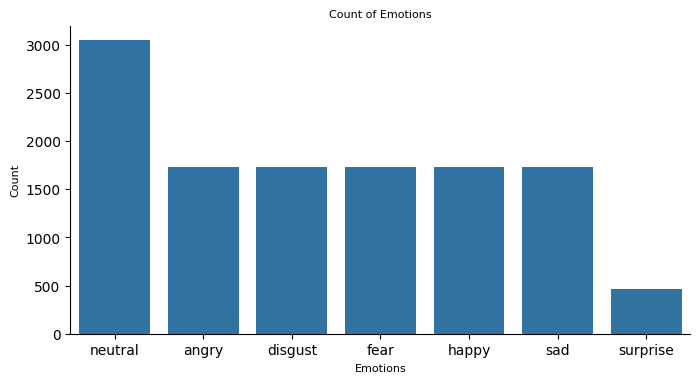

In [10]:
# Plotting the count of emotions
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.title('Count of Emotions', size=8)
sns.countplot(x='Emotions', data=data_path)
plt.xlabel('Emotions', size=8)
plt.ylabel('Count', size=8)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [11]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# Example usage:
# Assuming you have an audio file path and its corresponding emotion
# audio_path = 'path_to_audio_file'
# emotion = 'happy'
# audio_data, sample_rate = librosa.load(audio_path)
# create_waveplot(audio_data, sample_rate, emotion)
# create_spectrogram(audio_data, sample_rate, emotion)

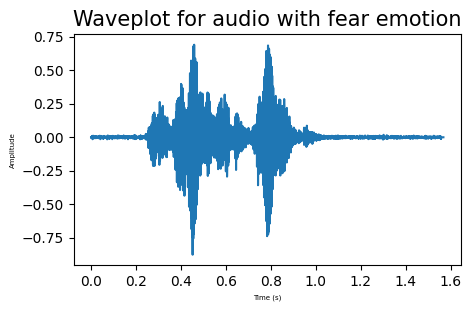

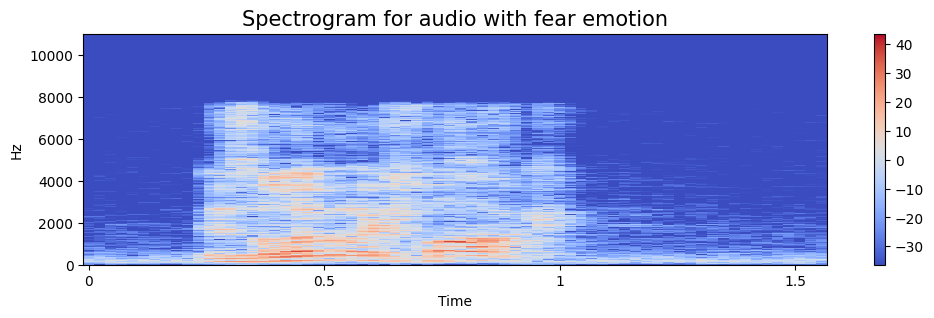

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(5, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(np.arange(len(data)) / sr, data)
    plt.xlabel('Time (s)', size=5)
    plt.ylabel('Amplitude', size=5)
    plt.show()

emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

# Create and display the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


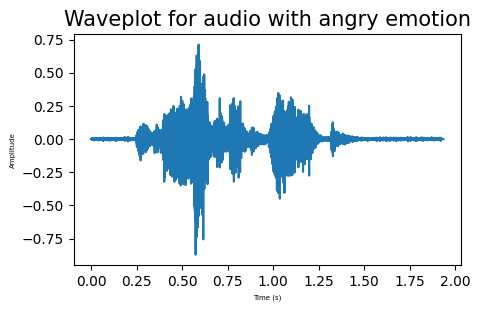

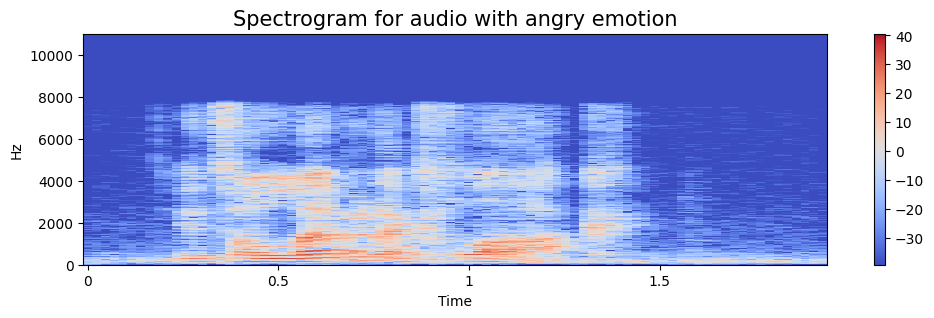

In [13]:
emotion = 'angry'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

# Create and display the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


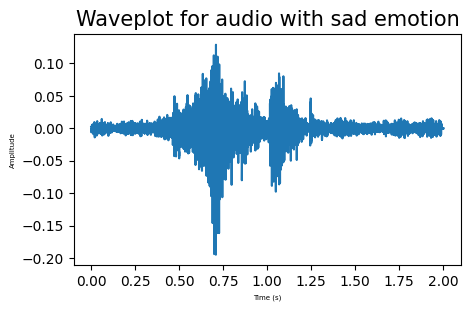

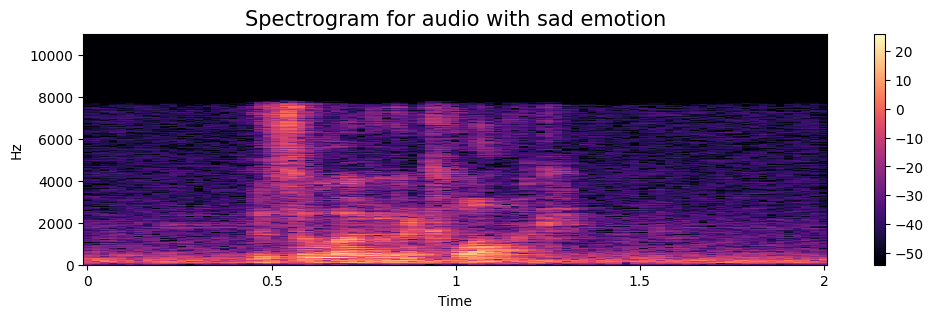

In [14]:
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

# Create and display the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


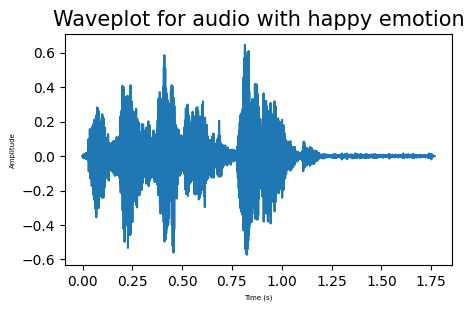

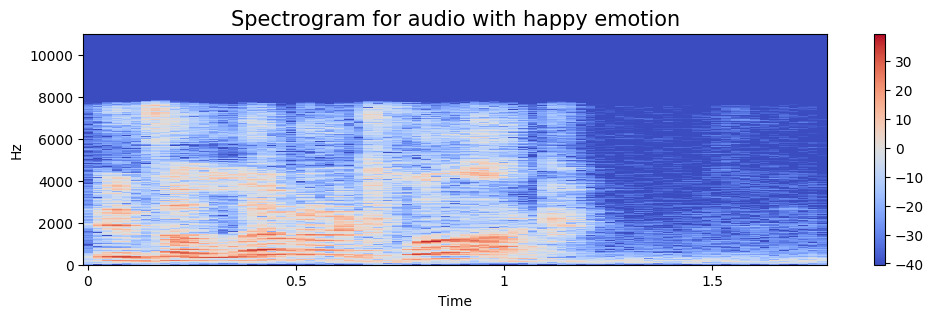

In [15]:
emotion = 'happy'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

# Create and display the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


In [16]:
!pip install pyrubberband
!pip install pydub

In [17]:
from pydub import AudioSegment

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    # Convert numpy array to pydub AudioSegment
    audio_segment = AudioSegment(data.tobytes(), frame_rate=len(data), sample_width=data.dtype.itemsize, channels=1)
    # Stretch using pydub
    stretched_audio = audio_segment.speedup(playback_speed=1 / rate)
    # Convert back to numpy array
    stretched_data = np.array(stretched_audio.get_array_of_samples())
    return stretched_data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Example usage:
# Assuming you have already defined the functions and loaded an audio file
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

# Applying each augmentation technique
noisy_data = noise(data)
stretched_data = stretch(data, rate=0.8)
shifted_data = shift(data)
pitched_data = pitch(data, sample_rate, pitch_factor=0.7)

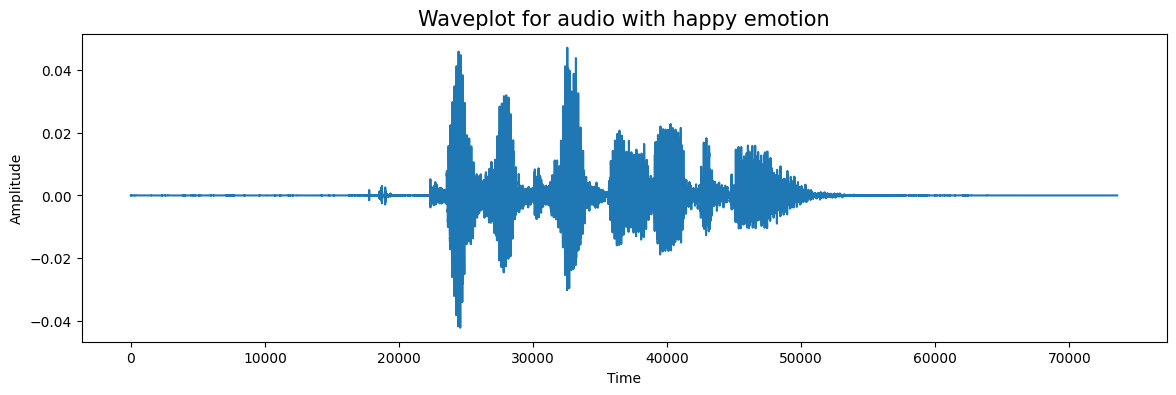

In [18]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

# Plotting the waveplot using matplotlib
plt.figure(figsize=(14, 4))
plt.plot(data)
plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# If you want to play the audio as well
Audio(data, rate=sample_rate)


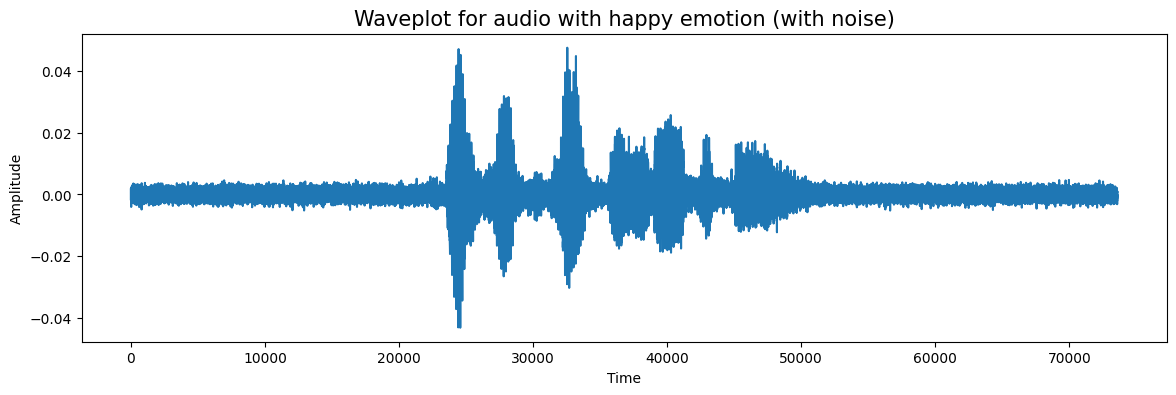

In [19]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

# Apply noise to the data
x = noise(data)

# Plotting the waveplot using matplotlib
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot for audio with {} emotion (with noise)'.format(emotion), size=15)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# If you want to play the audio with noise
Audio(x, rate=sample_rate)


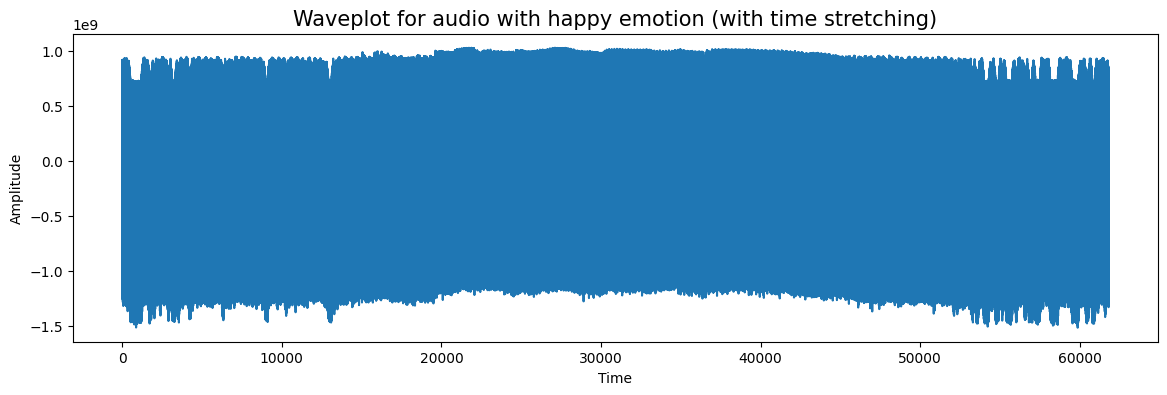

In [20]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

# Apply time stretching to the data
x = stretch(data)

# Plotting the waveplot using matplotlib
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot for audio with {} emotion (with time stretching)'.format(emotion), size=15)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# If you want to play the audio with time stretching
Audio(x, rate=sample_rate)


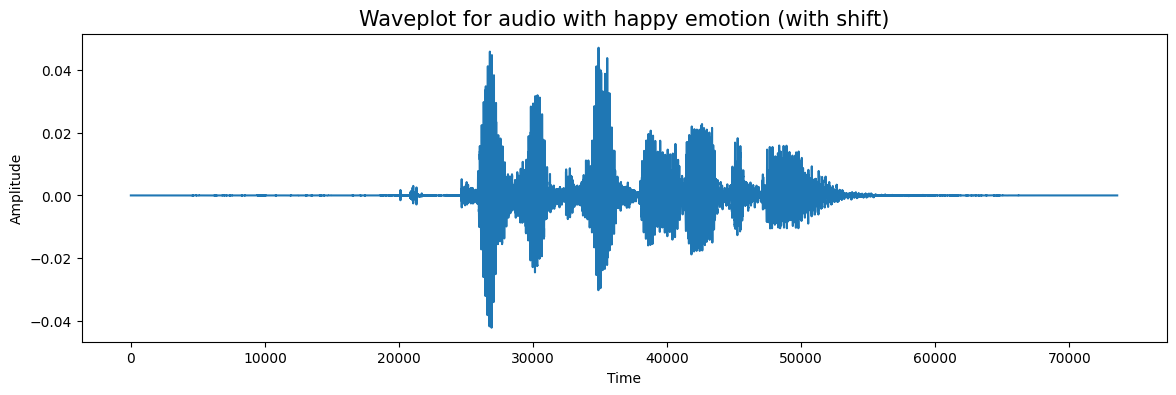

In [21]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

# Apply a shift to the data
x = shift(data)

# Plotting the waveplot using matplotlib
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot for audio with {} emotion (with shift)'.format(emotion), size=15)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# If you want to play the audio with shift
Audio(x, rate=sample_rate)


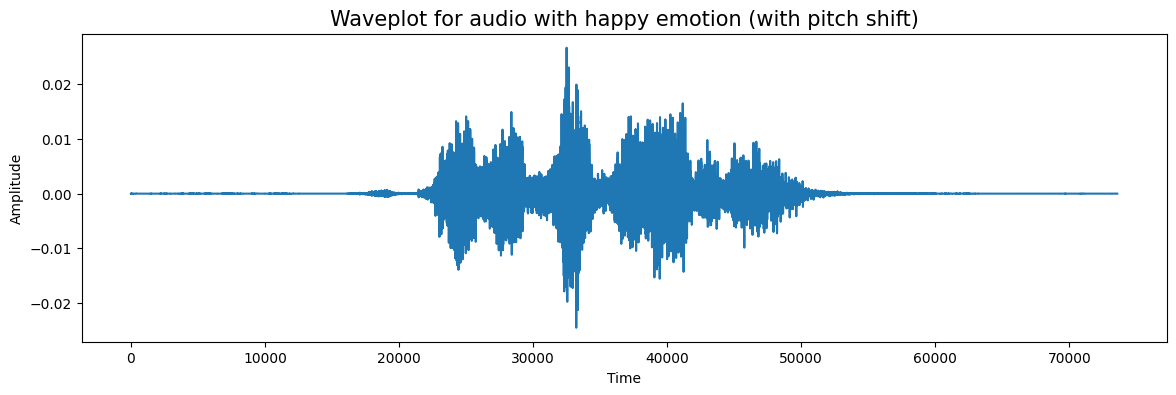

In [22]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

# Apply pitch shift to the data
x = pitch(data, sample_rate)

# Plotting the waveplot using matplotlib
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot for audio with {} emotion (with pitch shift)'.format(emotion), size=15)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# If you want to play the audio with pitch shift
Audio(x, rate=sample_rate)


In [23]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    # Ensure the data is in floating-point format
    data_float = librosa.util.normalize(data.astype(np.float32))

    return librosa.effects.pitch_shift(data_float, sr=sampling_rate, n_steps=pitch_factor)

def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))  # stacking vertically

    return result



In [24]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    features = get_features(path)
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [25]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [26]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,0.000004,0.000003,0.000002,0.000002,0.000005,0.000008,0.000007,0.000005,4.245834e-07,neutral
1,0.297598,0.787944,0.804327,0.793611,0.797216,0.789798,0.689046,0.673872,0.714786,0.747118,...,0.000020,0.000020,0.000017,0.000018,0.000021,0.000024,0.000023,0.000021,1.724265e-05,neutral
2,0.309710,0.826230,0.844929,0.860331,0.853838,0.782533,0.687366,0.669990,0.735744,0.769049,...,5.621992,6.917434,8.246397,7.075837,8.242353,11.339028,10.344178,6.626969,7.991757e-01,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,0.000007,0.000007,0.000007,0.000007,0.000012,0.000010,0.000011,0.000006,4.254087e-07,neutral
4,0.312450,0.754337,0.786417,0.809292,0.781572,0.777469,0.760791,0.650762,0.671431,0.714830,...,0.000063,0.000065,0.000059,0.000063,0.000066,0.000065,0.000064,0.000060,5.743375e-05,neutral


In [55]:
# Assuming Y is your original labels
unique_classes = np.unique(Y)
number_of_classes = len(unique_classes)

print("Number of unique classes:", number_of_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 2
Unique classes: [0. 1.]


In [56]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Assuming you already have Features DataFrame

X = Features.iloc[:, :-1].values
Y = Features['labels'].values

# Reshape Y to a column vector
Y = Y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
Y_onehot = encoder.fit_transform(Y).toarray()

# Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y_onehot, random_state=0, shuffle=True)

# Scaling our data with sklearn's StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Making our data compatible with the model
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# Print shapes for verification
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(27364, 162, 1) (27364, 7) (9122, 162, 1) (9122, 7)


In [57]:
# Assuming Y is your original labels
unique_classes = np.unique(Y)
number_of_classes = len(unique_classes)

print("Number of unique classes:", number_of_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 7
Unique classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [61]:
model = Sequential()

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 81, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 41, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_18 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 21, 128)          

In [62]:
from keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.0000001, verbose=1)

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50


428/428 [==============================] - 30s 65ms/step - loss: 1.6416 - accuracy: 0.3415 - val_loss: 1.4182 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 31s 73ms/step - loss: 1.3766 - accuracy: 0.4472 - val_loss: 1.2625 - val_accuracy: 0.4999 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 46s 107ms/step - loss: 1.2838 - accuracy: 0.4779 - val_loss: 1.1927 - val_accuracy: 0.5259 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 45s 106ms/step - loss: 1.2154 - accuracy: 0.5080 - val_loss: 1.1197 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 46s 107ms/step - loss: 1.1748 - accuracy: 0.5269 - val_loss: 1.1184 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 46s 107ms/step - loss: 1.1338 - accuracy: 0.5409 - val_loss: 1.0962 - val_accuracy: 0.5539 - lr: 0.0010
Epoch 7/50
428/428 [==============================] 

286/286 [==============================] - 5s 17ms/step - loss: 1.1199 - accuracy: 0.6016
Accuracy of our model on test data: 60.16%


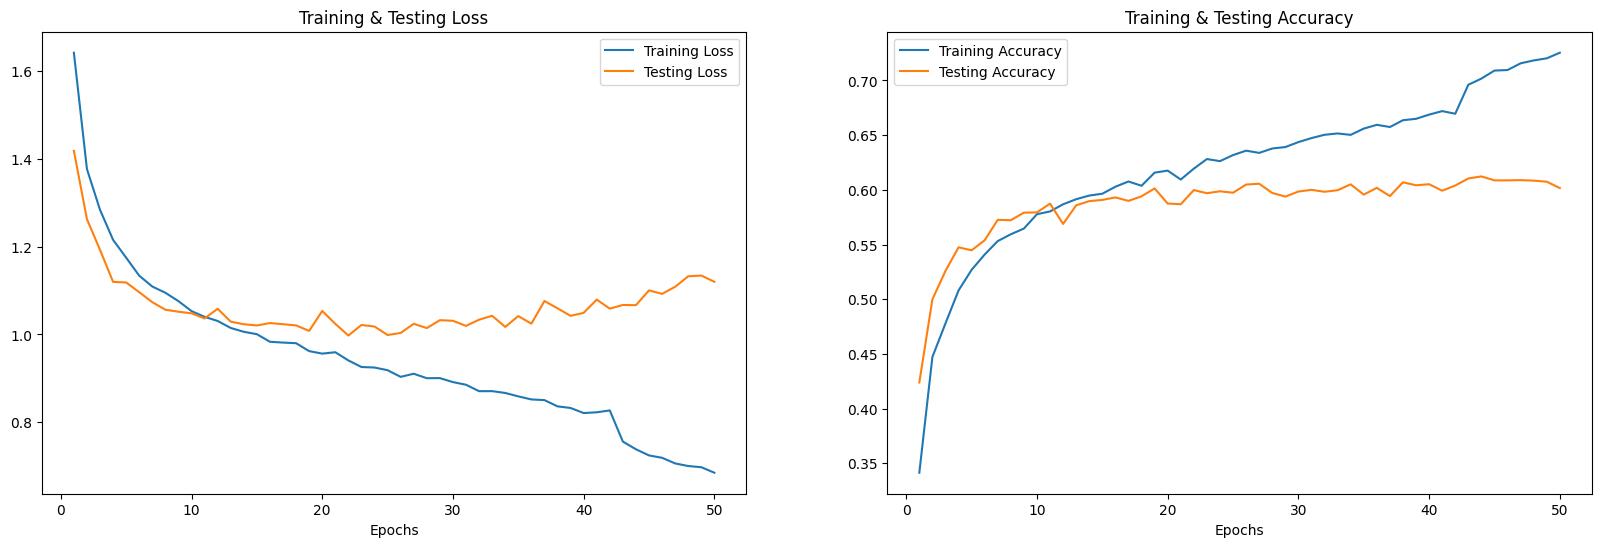

In [63]:
import matplotlib.pyplot as plt

# Evaluate model on test data
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Accuracy of our model on test data: {:.2f}%".format(accuracy))

# Plot training and testing metrics
epochs = range(1, 51)
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot loss
ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Plot accuracy
ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

In [64]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

286/286 [==============================] - 4s 15ms/step


,Predicted Labels,Actual Labels
0,sad,disgust
1,disgust,disgust
2,angry,angry
3,happy,disgust
4,fear,fear
5,disgust,fear
6,neutral,neutral
7,happy,happy
8,disgust,sad
9,neutral,sad


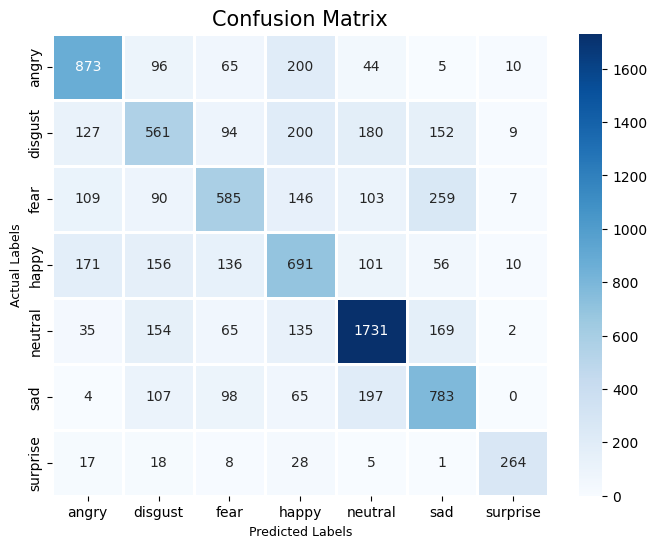

In [66]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 6))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=15)
plt.xlabel('Predicted Labels', size=9)
plt.ylabel('Actual Labels', size=9)
plt.show()

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.65      0.68      0.66      1293
     disgust       0.47      0.42      0.45      1323
        fear       0.56      0.45      0.50      1299
       happy       0.47      0.52      0.50      1321
     neutral       0.73      0.76      0.74      2291
         sad       0.55      0.62      0.58      1254
    surprise       0.87      0.77      0.82       341

    accuracy                           0.60      9122
   macro avg       0.62      0.60      0.61      9122
weighted avg       0.60      0.60      0.60      9122

